In [3]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
print(os.getcwd(), os.listdir())
DIR = './rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = './data'

/home/david/Desktop/Alvin/lung-cancer-detection-main ['rawData', 'processedData', 'data', 'methodology.jpeg', '.venv', 'MOBILENET.png', 'eval.txt', 'notebook.ipynb']


In [6]:
if not os.path.exists(DEST_DIR):
    !mkdir data && cd data && mkdir cancerous && mkdir non-cancerous

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            imgDest = curr.replace('rawData/normal', 'data/non-cancerous')
            cv2.imwrite(imgDest, segmentedImage)
        else:
            imgDest = curr.replace('rawData/adenocarcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/large.cell.carcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/squamous.cell.carcinoma', 'data/cancerous')
            cv2.imwrite(imgDest, segmentedImage)
print("Processed data directory created successfully at", DEST_DIR)

Processed data directory created successfully at ./data


<div style='font-size:100%;'>
    <a id='comparison'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Comparison between processed and unprocessed image</center>
    </h1>
</div>

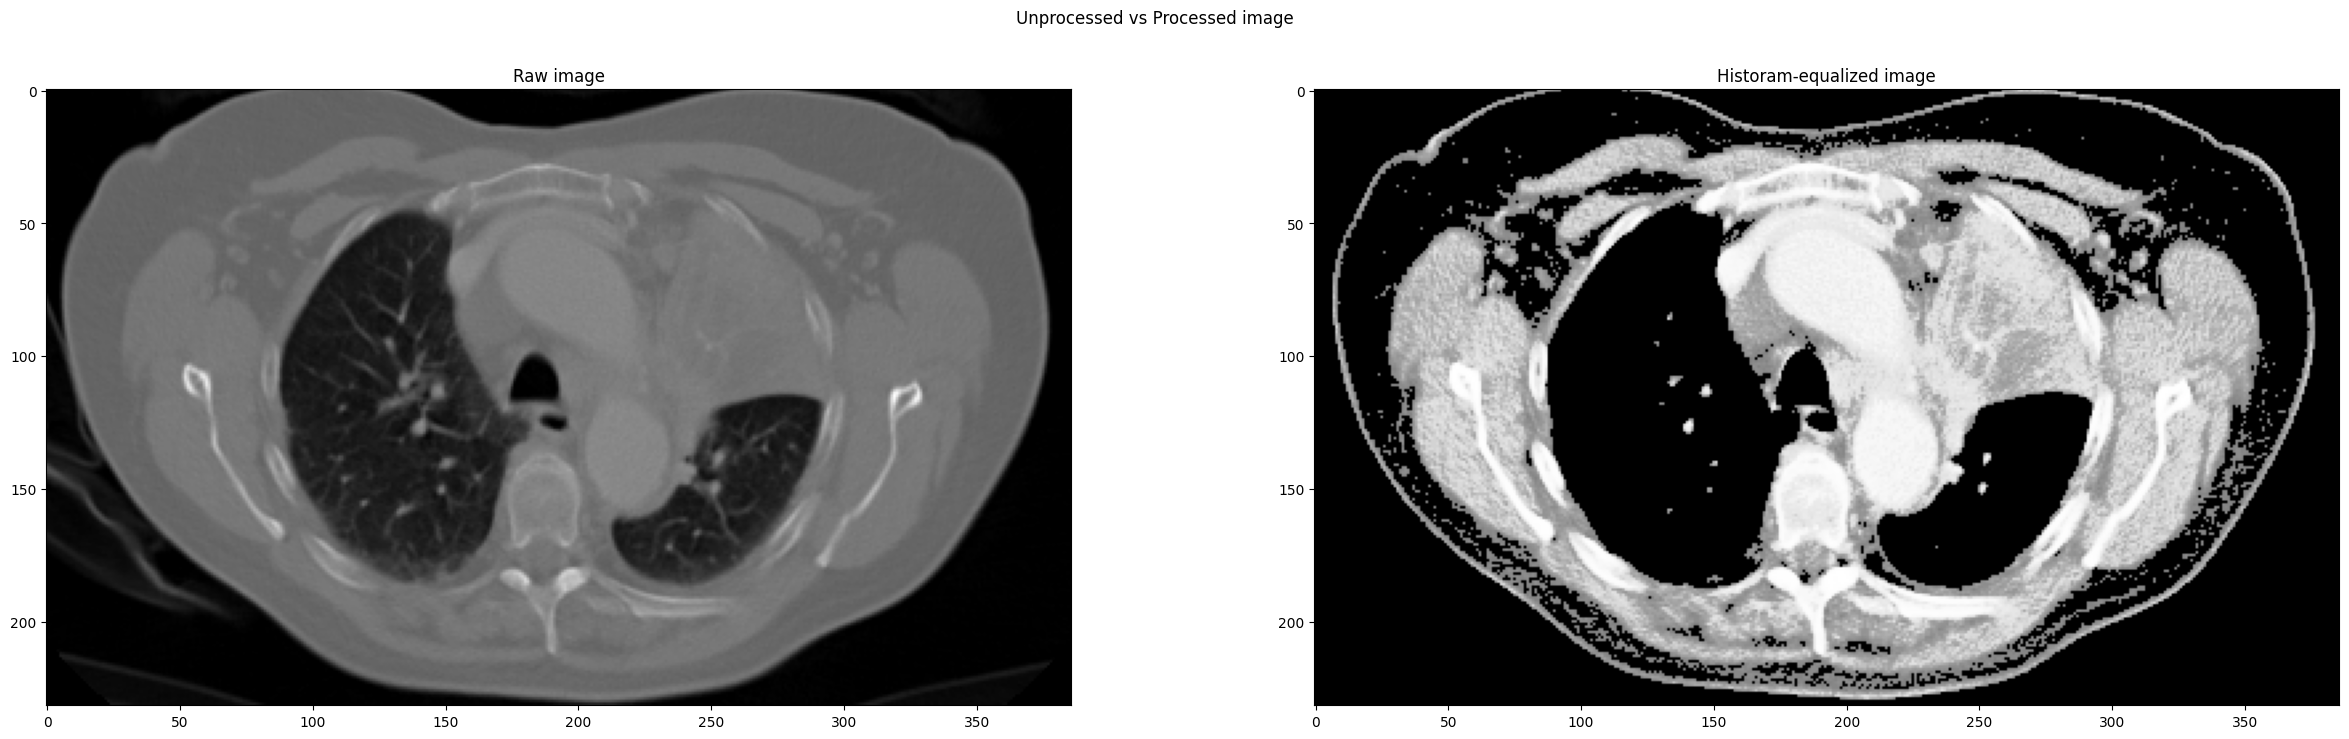

In [7]:
plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(DIR, CATS[0], 'adenocarcinoma10.png')))
plt.title('Raw image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(os.path.join(DEST_DIR,'cancerous', 'adenocarcinoma10.png')))
plt.title('Historam-equalized image')
plt.suptitle('Unprocessed vs Processed image')
plt.show()

<div style='font-size:100%;'>
    <a id='split'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Splitting the processed images</center>
    </h1>
</div>

In [8]:
FINAL_DIR = './processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2)) 

In [10]:
BATCH_SIZE=32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,                  
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [12]:
train_dataset  = train_datagen.flow_from_directory(directory = './processedData/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 699 images belonging to 2 classes.


In [13]:
valid_dataset = valid_datagen.flow_from_directory(directory = './processedData/val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 99 images belonging to 2 classes.


In [14]:
test_dataset = test_datagen.flow_from_directory(directory = './processedData/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 202 images belonging to 2 classes.


<div style='font-size:100%;'>
    <a id='nn'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Neural nets</center>
    </h1>
</div>

In [15]:
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),  
      tf.keras.metrics.AUC(name='AUC'),
      F1,
]

def plot_history(hist, name):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].plot(hist.history['Accuracy'])
  axs[0].plot(hist.history['val_Accuracy'])
  axs[0].set_title(f'{name} Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'val', 'F1', 'Recall'], loc='upper left')

  axs[1].plot(hist.history['loss'])
  axs[1].plot(hist.history['val_loss'])
  axs[1].set_title(f'{name} Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'val'], loc='upper left')

  axs[2].plot(hist.history['Precision'])
  axs[2].plot(hist.history['val_Precision'])
  axs[2].set_title(f'{name} Precision')
  axs[2].set_ylabel('Precision')
  axs[2].set_xlabel('Epoch')
  axs[2].legend(['train', 'val'], loc='upper left')

  plt.show()


2024-05-27 09:57:32.749679: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


<h1 align="center" ><a id='vgg16'><b>VGG16<b></a></h1>

In [29]:
VGG16_base = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in VGG16_base.layers:
    layer.trainable = False

VGG16=tf.keras.Sequential()
VGG16.add(VGG16_base)
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Flatten())
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dense(1,activation='sigmoid'))

VGG16.summary()

VGG16.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG16.keras', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG16_history = VGG16.fit(train_dataset,validation_data=valid_dataset, epochs = 10, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - AUC: 0.5378 - Accuracy: 0.6757 - Precision: 0.3307 - Recall: 0.3733 - f1: 7.3723 - loss: 0.6584 - val_AUC: 0.7320 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_loss: 0.8001 - learning_rate: 0.0010
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - AUC: 0.6454 - Accuracy: 0.7649 - Precision: 0.4152 - Recall: 0.2476 - f1: 5.0716 - loss: 0.5381 - val_AUC: 0.8132 - val_Accuracy: 0.8081 - val_Precision: 1.0000 - val_Recall: 0.0952 - val_f1: 0.8819 - val_loss: 0.4376 - learning_rate: 0.0010
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - AUC: 0.7263 - Accuracy: 0.7857 - Precision: 0.5207 - Recall: 0.2217 - f1: 3.8554 - loss: 0.4821 - val_AUC: 0.8666 - val_Accuracy: 0.8485 - val_Precision: 1.0000 - val_Recall: 0.2857 - val_f1: 2.2854 - val_loss: 0.3614 - learning_rate: 0.0010
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - AUC: 0.7743 - Accuracy: 0.8133 - Precision: 0.7228 - R

In [33]:
VGG16_scores = VGG16.evaluate(test_dataset, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - AUC: 0.9988 - Accuracy: 0.9881 - Precision: 1.0000 - Recall: 0.9525 - f1: 8.1966 - loss: 0.0991


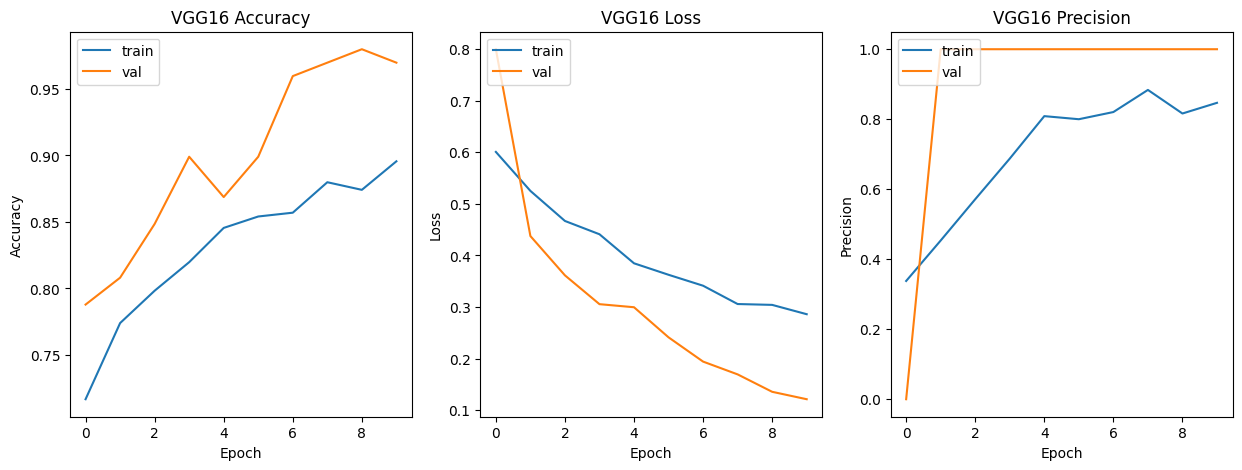

In [34]:
plot_history(VGG16_history, 'VGG16')

<h1 align="center" ><a id='mobilenet'><b>MobileNet<b></a></h1>

In [35]:
MOBILENET_base =  tf.keras.applications.MobileNet(input_shape=(224,224,3), include_top= False)

for layer in MOBILENET_base.layers:
    layer.trainable = False

MOBILENET=tf.keras.Sequential()
MOBILENET.add(MOBILENET_base)
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Flatten())
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dense(1,activation='sigmoid'))

MOBILENET.summary()

MOBILENET.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [36]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('MOBILENET.keras', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

MOBILENET_history = MOBILENET.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 536ms/step - AUC: 0.8809 - Accuracy: 0.8191 - Precision: 0.5909 - Recall: 0.7484 - f1: 9.6339 - loss: 0.6506 - val_AUC: 0.6123 - val_Accuracy: 0.2121 - val_Precision: 0.2121 - val_Recall: 1.0000 - val_f1: 8.5981 - val_loss: 5.6213 - learning_rate: 0.0010
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 501ms/step - AUC: 0.8554 - Accuracy: 0.8786 - Precision: 0.7409 - Recall: 0.6496 - f1: 6.0655 - loss: 0.4581 - val_AUC: 0.9438 - val_Accuracy: 0.2323 - val_Precision: 0.2165 - val_Recall: 1.0000 - val_f1: 8.5201 - val_loss: 1.6730 - learning_rate: 0.0010
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 501ms/step - AUC: 0.9198 - Accuracy: 0.8959 - Precision: 0.7696 - Recall: 0.7229 - f1: 6.1229 - loss: 0.3617 - val_AUC: 0.9637 - val_Accuracy: 0.6263 - val_Precision: 0.3571 - val_Recall: 0.9524 - val_f1: 7.4783 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 497ms/step - AUC: 0.9252 - Accuracy: 0.9117 - Precision: 0.8517 - R

In [37]:
MOBILENET_scores = MOBILENET.evaluate(test_dataset, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - AUC: 1.0000 - Accuracy: 0.9895 - Precision: 0.9525 - Recall: 1.0000 - f1: 6.5316 - loss: 0.0592


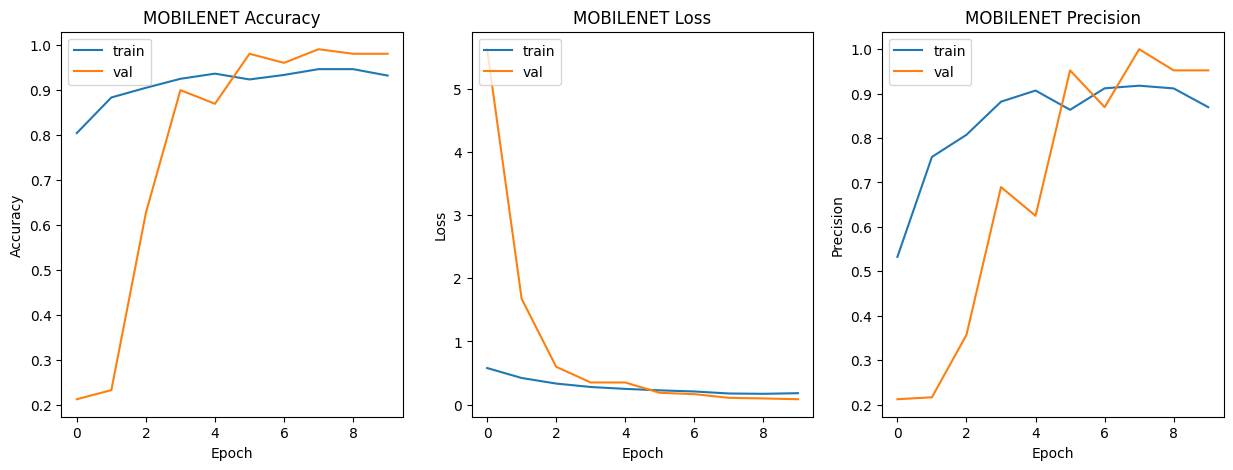

In [38]:
plot_history(MOBILENET_history, 'MOBILENET')

<h1 align="center" ><a id='vgg19'><b>VGG19<b></a></h1>

In [39]:
VGG19_base = tf.keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in VGG19_base.layers:
    layer.trainable = False

VGG19=tf.keras.Sequential()
VGG19.add(VGG19_base)
VGG19.add(tf.keras.layers.Dropout(0.5))
VGG19.add(tf.keras.layers.Flatten())
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Activation('relu'))
VGG19.add(tf.keras.layers.Dropout(0.5))
VGG19.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Activation('relu'))
VGG19.add(tf.keras.layers.Dropout(0.5))
VGG19.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Activation('relu'))
VGG19.add(tf.keras.layers.Dense(1,activation='sigmoid'))

VGG19.summary()

VGG19.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [40]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG19.keras', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG19_history = VGG19.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - AUC: 0.8266 - Accuracy: 0.8128 - Precision: 0.6025 - Recall: 0.5023 - f1: 6.0721 - loss: 0.6017 - val_AUC: 0.9081 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - AUC: 0.6549 - Accuracy: 0.8048 - Precision: 0.4031 - Recall: 0.1643 - f1: 3.0146 - loss: 0.4863 - val_AUC: 0.9441 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_loss: 0.3744 - learning_rate: 0.0010
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - AUC: 0.7965 - Accuracy: 0.8271 - Precision: 0.6761 - Recall: 0.2734 - f1: 3.4778 - loss: 0.4293 - val_AUC: 0.9490 - val_Accuracy: 0.8081 - val_Precision: 1.0000 - val_Recall: 0.0952 - val_f1: 0.8333 - val_loss: 0.3246 - learning_rate: 0.0010
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - AUC: 0.7534 - Accuracy: 0.8279 - Preci

In [41]:
VGG19_scores = VGG19.evaluate(test_dataset, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - AUC: 0.9980 - Accuracy: 0.9609 - Precision: 0.9899 - Recall: 0.8474 - f1: 7.1301 - loss: 0.1301


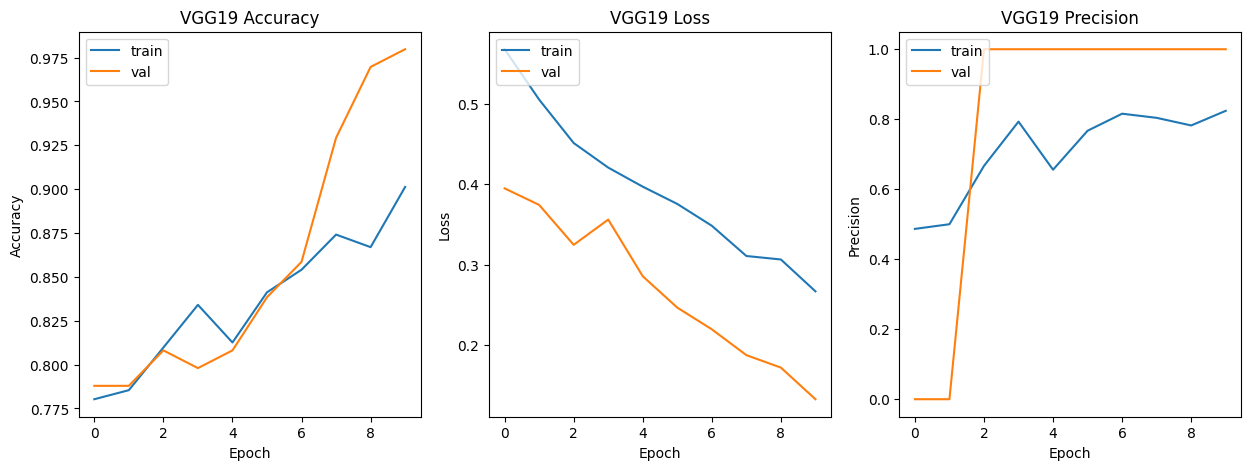

In [42]:
plot_history(VGG19_history, 'VGG19')

<h1 align="center" ><a id='xception'><b>Xception<b></a></h1>

In [43]:
Xception_base = tf.keras.applications.Xception(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in Xception_base.layers:
    layer.trainable = False

Xception=tf.keras.Sequential()
Xception.add(Xception_base)
Xception.add(tf.keras.layers.Dropout(0.5))
Xception.add(tf.keras.layers.Flatten())
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Activation('relu'))
Xception.add(tf.keras.layers.Dropout(0.5))
Xception.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Activation('relu'))
Xception.add(tf.keras.layers.Dropout(0.5))
Xception.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Activation('relu'))
Xception.add(tf.keras.layers.Dense(1,activation='sigmoid'))

Xception.summary()

Xception.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [44]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('Xception.keras', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

Xception_history = Xception.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - AUC: 0.8234 - Accuracy: 0.7966 - Precision: 0.5349 - Recall: 0.5752 - f1: 7.6267 - loss: 0.6353 - val_AUC: 0.9481 - val_Accuracy: 0.8081 - val_Precision: 0.5263 - val_Recall: 0.9524 - val_f1: 6.6433 - val_loss: 0.4431 - learning_rate: 0.0010
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - AUC: 0.8380 - Accuracy: 0.8199 - Precision: 0.5652 - Recall: 0.5016 - f1: 5.7721 - loss: 0.4577 - val_AUC: 0.9710 - val_Accuracy: 0.8384 - val_Precision: 0.5676 - val_Recall: 1.0000 - val_f1: 6.6190 - val_loss: 0.3848 - learning_rate: 0.0010
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - AUC: 0.8741 - Accuracy: 0.8617 - Precision: 0.7889 - Recall: 0.5224 - f1: 5.4259 - loss: 0.3945 - val_AUC: 0.9841 - val_Accuracy: 0.9293 - val_Precision: 0.7692 - val_Recall: 0.9524 - val_f1: 5.7421 - val_loss: 0.2827 - learning_rate: 0.0010
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - AUC: 0.9095 - Accuracy: 0.9018 - Precision: 0.8448 - Recall: 0.628

In [45]:
Xception_scores = Xception.evaluate(test_dataset, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - AUC: 0.9986 - Accuracy: 0.9818 - Precision: 0.9560 - Recall: 0.9656 - f1: 7.0423 - loss: 0.0834


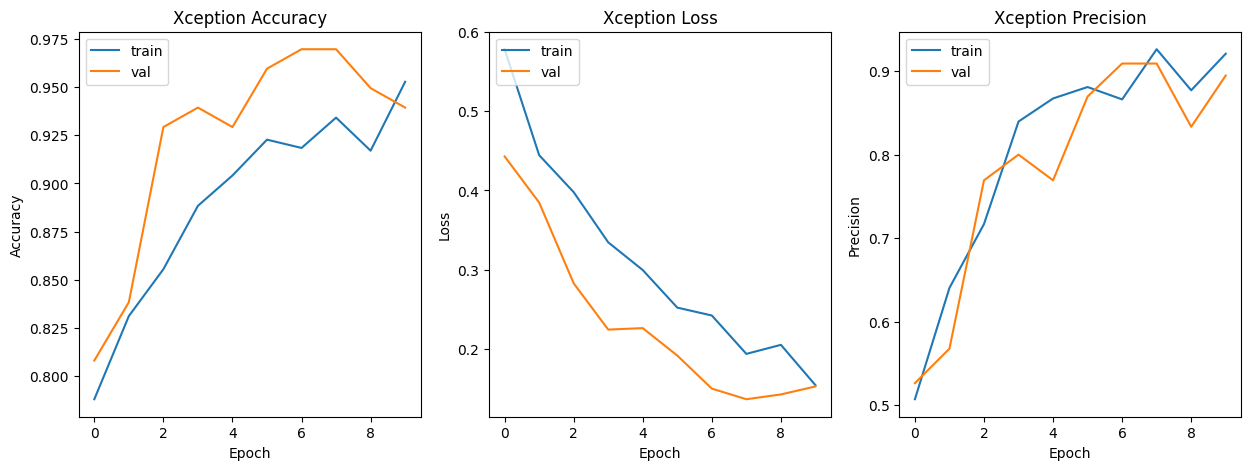

In [46]:
plot_history(Xception_history, 'Xception')

<h1 align="center" ><a id='resnet50'><b>ResNet50<b></a></h1>

In [47]:
ResNet50_base = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in ResNet50_base.layers:
    layer.trainable = False

ResNet50=tf.keras.Sequential()
ResNet50.add(ResNet50_base)
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Flatten())
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dense(1,activation='sigmoid'))

ResNet50.summary()

ResNet50.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [48]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('ResNet50.keras', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

ResNet50_history = ResNet50.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - AUC: 0.8148 - Accuracy: 0.8165 - Precision: 0.5929 - Recall: 0.5205 - f1: 6.1220 - loss: 0.6045 - val_AUC: 0.9002 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_loss: 0.5942 - learning_rate: 0.0010
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - AUC: 0.7045 - Accuracy: 0.7890 - Precision: 0.5569 - Recall: 0.1952 - f1: 3.4158 - loss: 0.4918 - val_AUC: 0.9124 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - AUC: 0.7252 - Accuracy: 0.7648 - Precision: 0.5030 - Recall: 0.0784 - f1: 1.7995 - loss: 0.4867 - val_AUC: 0.9005 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_loss: 0.3963 - learning_rate: 0.0010
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - AUC: 0.7110 - Accuracy: 0.8088

In [49]:
ResNet50_scores = ResNet50.evaluate(test_dataset, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - AUC: 0.9649 - Accuracy: 0.9332 - Precision: 0.9218 - Recall: 0.7579 - f1: 6.2460 - loss: 0.2606


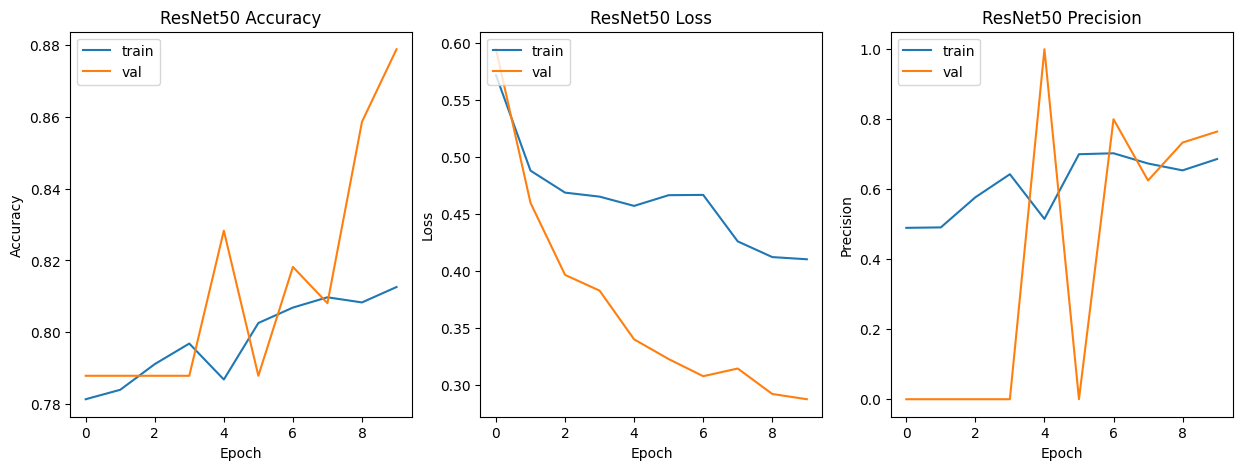

In [50]:
plot_history(ResNet50_history, 'ResNet50')

## Testing the models

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


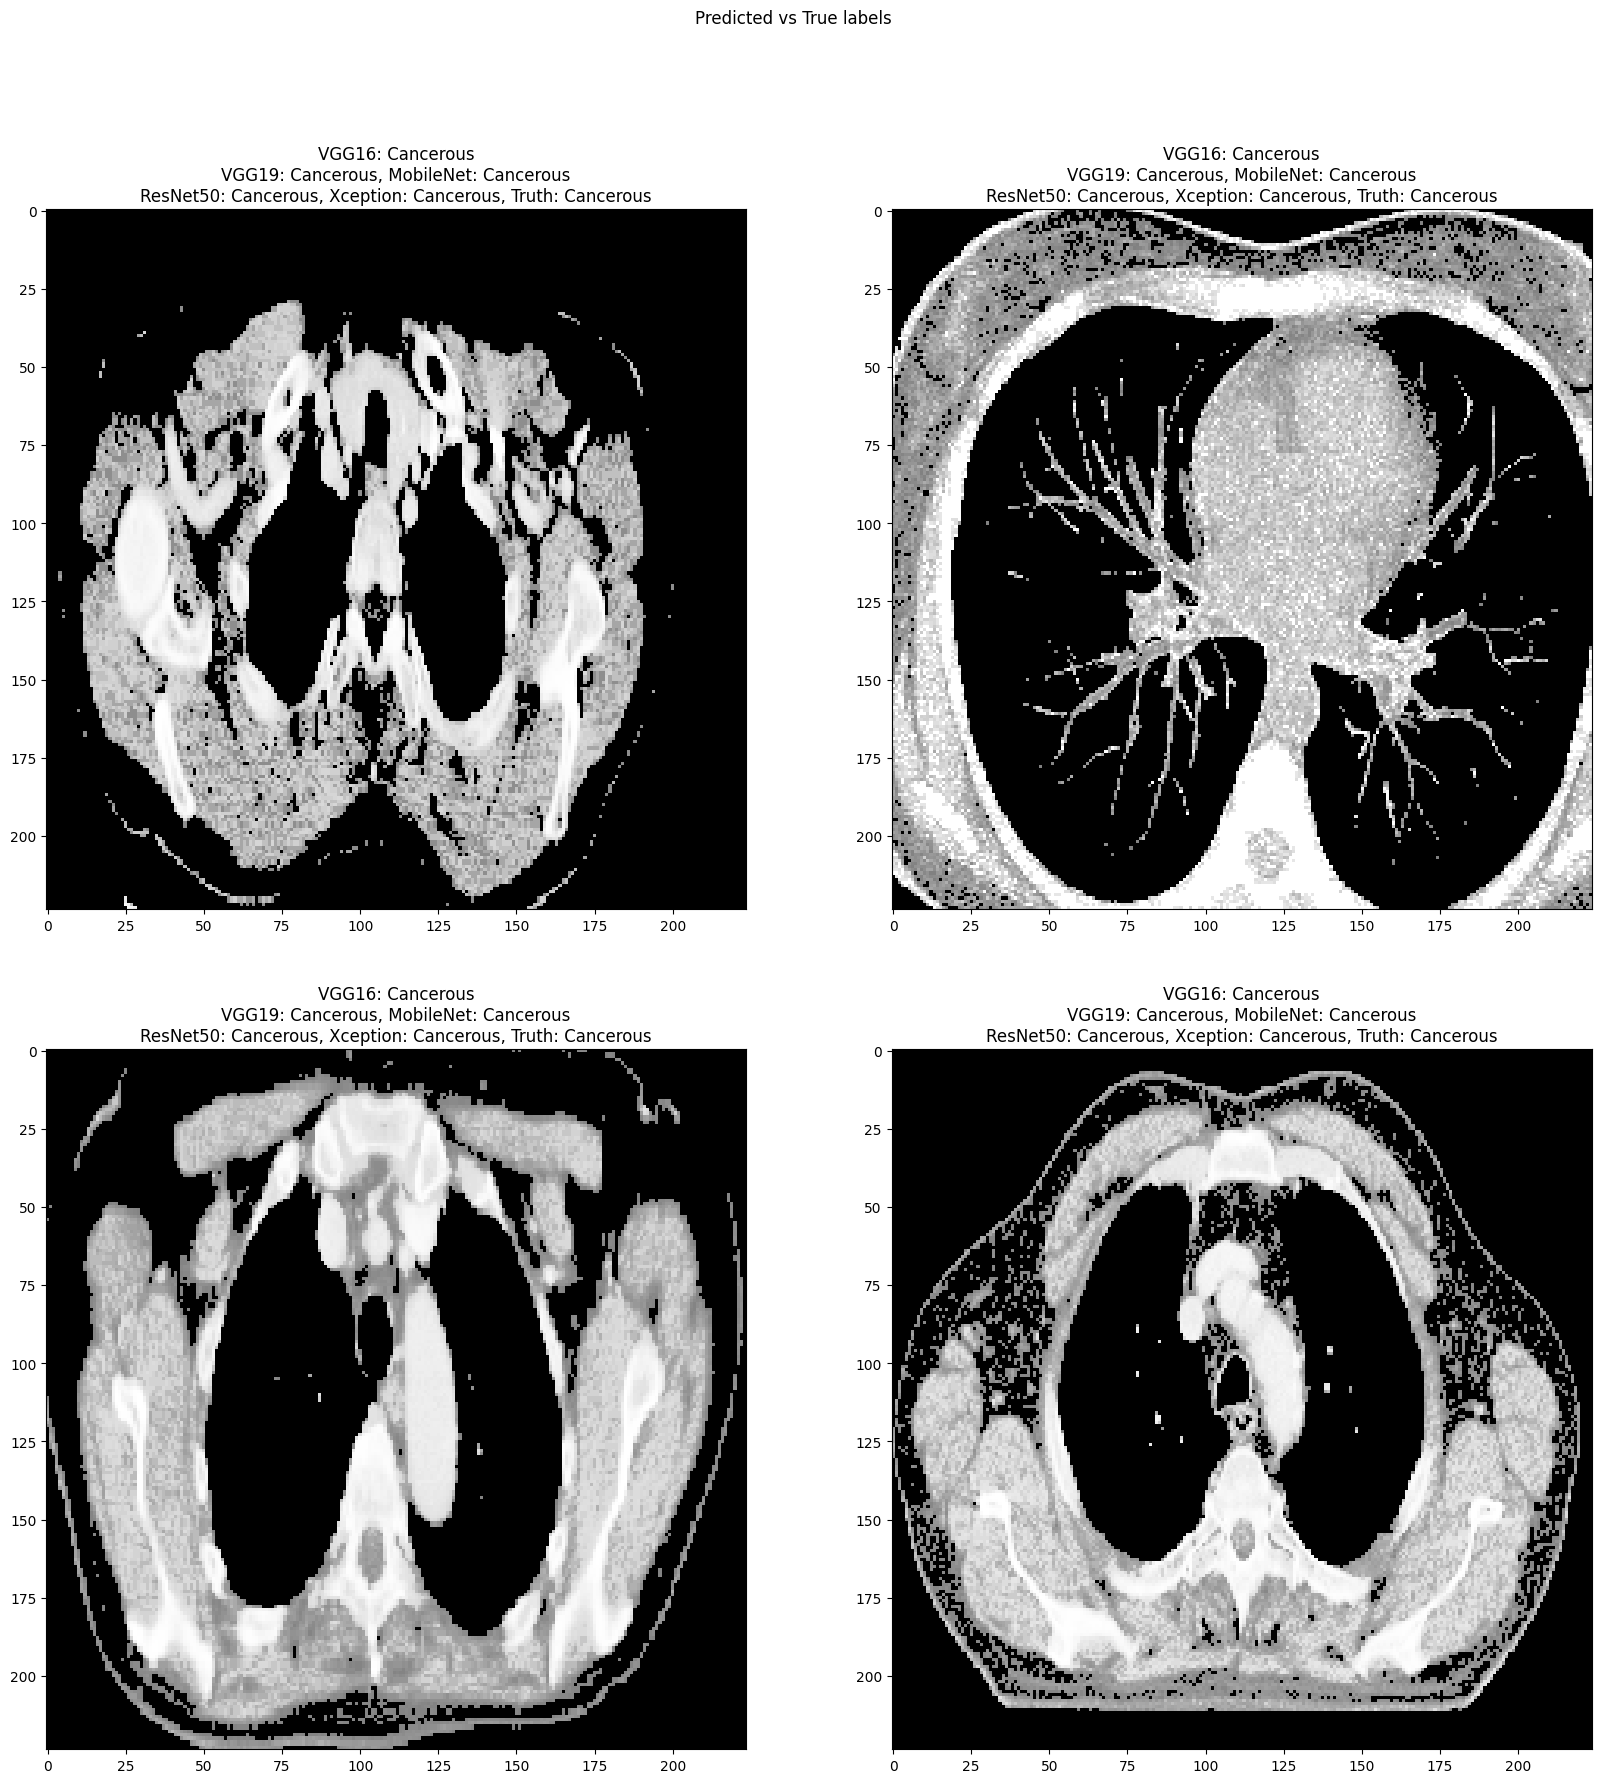

In [72]:
batch = next(test_dataset)

def predAll(batch, i):
  label_dict = {0: 'Cancerous', 1: 'Non-Cancerous'}
  vgg16Pred = 0 if VGG16.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  mobilenetPred = 0 if MOBILENET.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  vgg19Pred = 0 if VGG19.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  xceptionPred = 0 if Xception.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  resnet50Pred = 0 if ResNet50.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1

  return f'VGG16: {label_dict[vgg16Pred]}\nVGG19: {label_dict[vgg19Pred]}, MobileNet: {label_dict[mobilenetPred]}\nResNet50: {label_dict[resnet50Pred]}, Xception: {label_dict[xceptionPred]}, Truth: {label_dict[int(batch[1][i])]}'


plt.figure(figsize=(20, 20))

ax1 = plt.subplot(2, 2, 1)
plt.imshow(batch[0][0])
label = predAll(batch, 0)
ax1.set_title(label)


ax2 = plt.subplot(2, 2, 2)
plt.imshow(batch[0][5])
label = predAll(batch, 1)
ax2.set_title(label)

ax3 = plt.subplot(2, 2, 3)
plt.imshow(batch[0][2])
label = predAll(batch, 2)
ax3.set_title(label)

ax4 = plt.subplot(2, 2, 4)
plt.imshow(batch[0][3])
label = predAll(batch, 3)
ax4.set_title(label)


plt.suptitle('Predicted vs True labels')
plt.show()


In [67]:
eval = [VGG16_scores, VGG19_scores, MOBILENET_scores, ResNet50_scores, Xception_scores]
eval

[[0.09363240748643875,
  0.9900990128517151,
  1.0,
  0.9545454382896423,
  0.9991369247436523,
  6.127891540527344],
 [0.1376359462738037,
  0.9554455280303955,
  0.9729729890823364,
  0.8181818127632141,
  0.994102418422699,
  5.671192646026611],
 [0.058334048837423325,
  0.9900990128517151,
  0.95652174949646,
  1.0,
  1.0,
  6.419047832489014],
 [0.271241158246994,
  0.9405940771102905,
  0.9444444179534912,
  0.7727272510528564,
  0.9451956748962402,
  5.601648807525635],
 [0.08016505092382431,
  0.9801980257034302,
  0.976190447807312,
  0.9318181872367859,
  0.9979861974716187,
  6.107351779937744]]

<div style='font-size:100%;'>
    <a id='analysis'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> Comparative analysis of the models </center>
    </h1>
</div></center>

In [68]:
indices = ['VGG16', 'VGG19', 'MobileNet', 'ResNet', 'Xception',]
scores = pd.DataFrame({'Accuracy': [item[1] for item in eval],'Precision': [item[2] for item in eval], 'Recall': [item[3] for item in eval], 'AUC': [item[4] for item in eval], 'F1': [item[5] for item in eval]}, index=indices)
scores

,Accuracy,Precision,Recall,AUC,F1
VGG16,0.990099,1.000000,0.954545,0.999137,6.127892
VGG19,0.955446,0.972973,0.818182,0.994102,5.671193
MobileNet,0.990099,0.956522,1.000000,1.000000,6.419048
ResNet,0.940594,0.944444,0.772727,0.945196,5.601649
Xception,0.980198,0.976190,0.931818,0.997986,6.107352


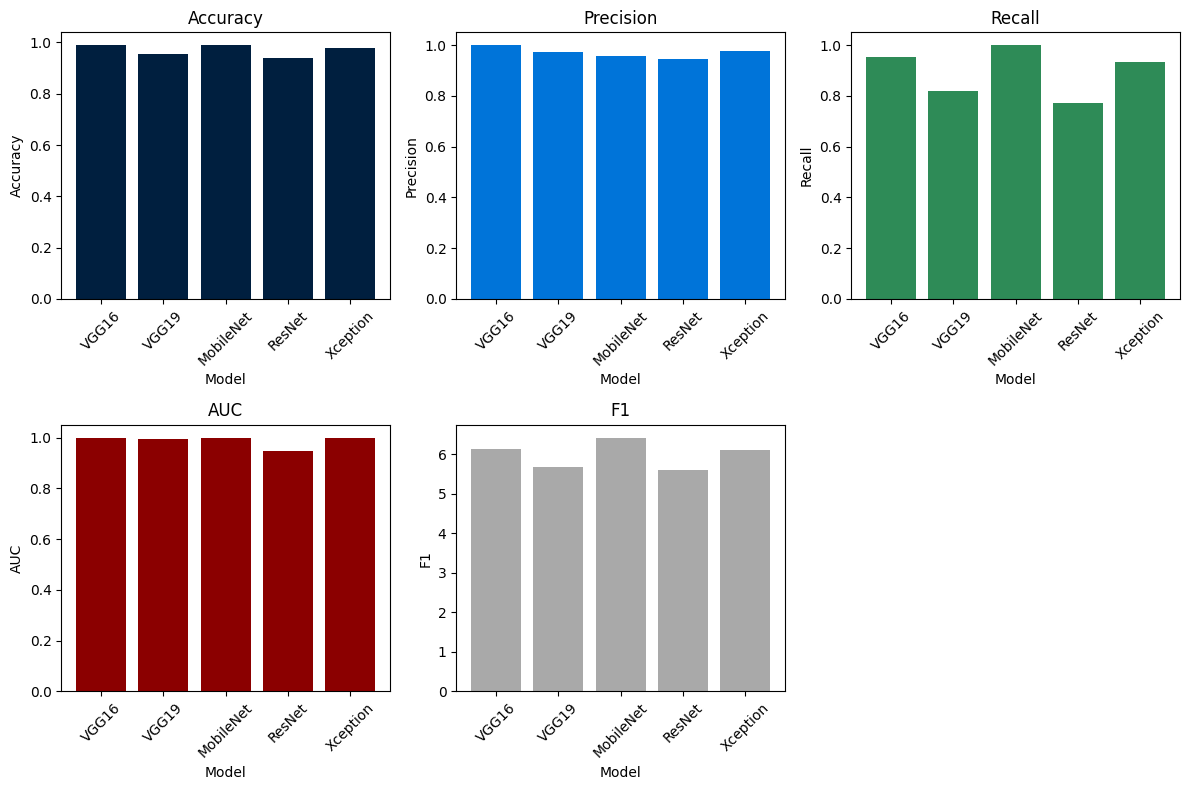

In [69]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs = axs.ravel()

colors = ['#001f3f', '#0074D9', '#2E8B57', '#8B0000', '#A9A9A9']

for i, column in enumerate(scores.columns):
    axs[i].bar(scores.index, scores[column], color=colors[i])
    axs[i].set_xlabel('Model')
    axs[i].set_ylabel(column)
    axs[i].set_title(f'{column}')
    axs[i].tick_params(axis='x', rotation=45)

for i in range(len(scores.columns), len(axs)):
    plt.delaxes(axs[i])

plt.tight_layout()
plt.show()


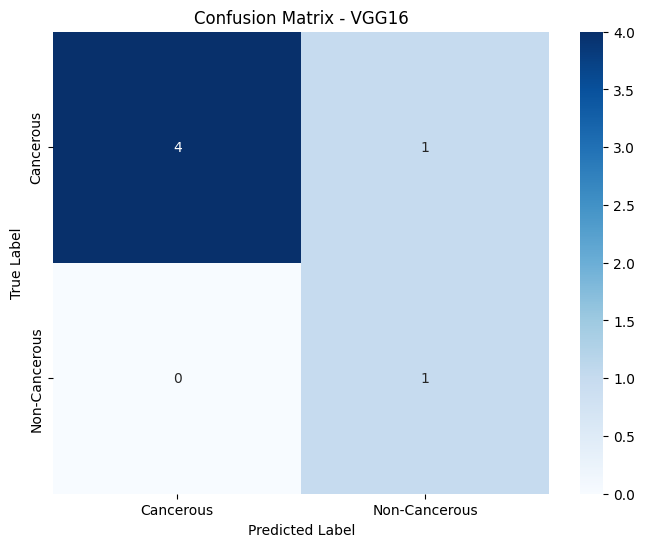

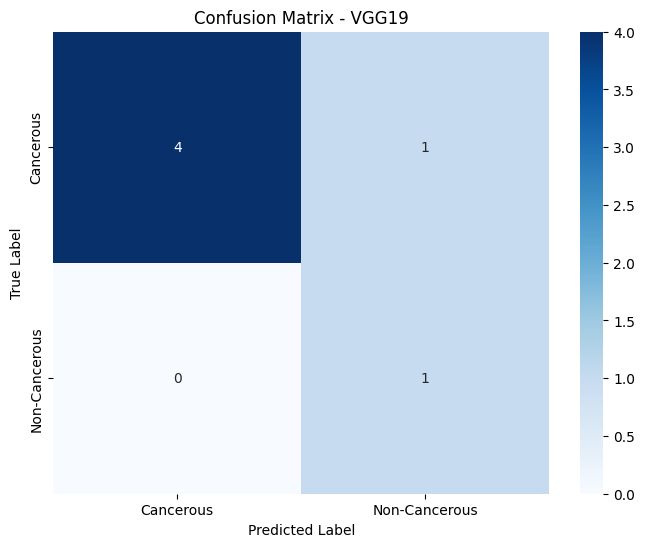

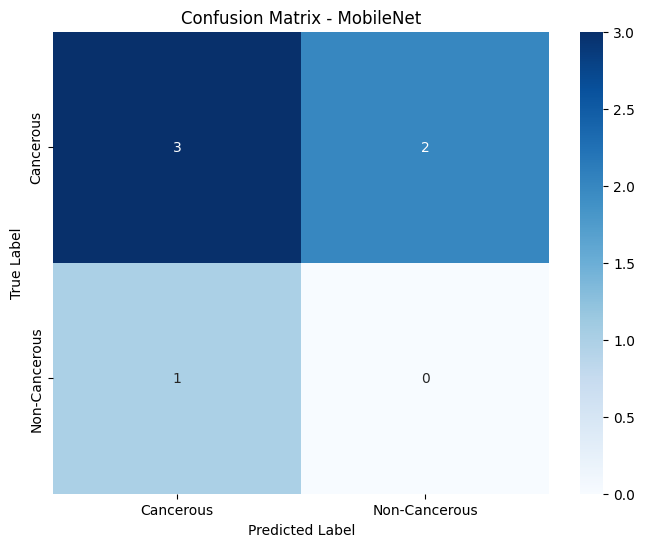

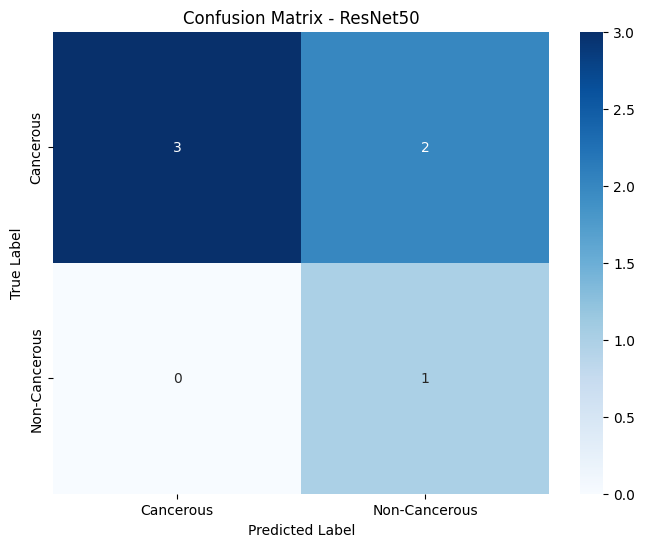

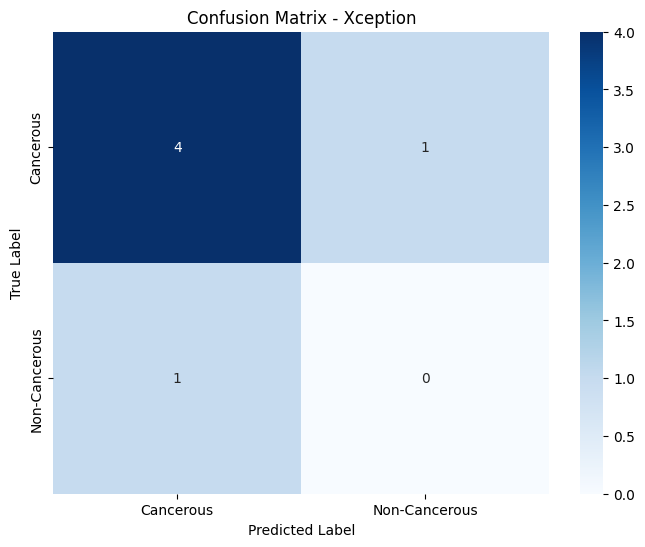

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the true labels
true_labels = np.array(['Cancerous', 'Cancerous', 'Cancerous', 'Cancerous', 'Non-Cancerous', 'Cancerous'])

# Define the predicted labels for each model
predictions = {
    'VGG16': np.array(['Cancerous', 'Non-Cancerous', 'Cancerous', 'Cancerous', 'Non-Cancerous', 'Cancerous']),
    'VGG19': np.array(['Cancerous', 'Cancerous', 'Non-Cancerous', 'Cancerous', 'Non-Cancerous', 'Cancerous']),
    'MobileNet': np.array(['Cancerous', 'Cancerous', 'Cancerous', 'Non-Cancerous', 'Cancerous', 'Non-Cancerous']),
    'ResNet50': np.array(['Cancerous', 'Non-Cancerous', 'Non-Cancerous', 'Cancerous', 'Non-Cancerous', 'Cancerous']),
    'Xception': np.array(['Non-Cancerous', 'Cancerous', 'Cancerous', 'Cancerous', 'Cancerous', 'Cancerous'])
}

# Define the list of model names
model_names = ['VGG16', 'VGG19', 'MobileNet', 'ResNet50', 'Xception']

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get the unique class names
class_names = np.unique(true_labels)

# Plot the confusion matrix for each model
for model in model_names:
    cm = confusion_matrix(true_labels, predictions[model])
    plot_confusion_matrix(cm, model, class_names)


In [71]:
MOBILENET.save('mobilenet_model.h5')